<a href="https://colab.research.google.com/github/obeabi/Assignments/blob/master/Main_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN Assignment 
## Written by Abiola Obembe
### Date: 2021-04-04
### Course: ML masters with deployment and deep learning
### Objective: predict how many points NBA players scored in the 2013-2014    season using XGBoost
-----------------------------------------------------------------------------
### ----------  Assignment starts here -------------------------------------------------

## Dataset

Before we dive into the algorithm, let’s take a look at our data. Each row in
the data contains information on how a player performed in the 2013-2014
NBA season.
Download 'nba_2013.csv' file from this link:
https://www.dropbox.com/s/b3nv38jjo5dxcl6/nba_2013.csv?dl=0
Here are some selected columns from the data:
player - name of the player
pos - the position of the player
g - number of games the player was in
gs - number of games the player started
pts - total points the player scored
There are many more columns in the data, mostly containing information
about average player game performance over the course of the season.
See this site for an explanation of the rest of them.
We can read our dataset in and figure out which columns are present:



In [1]:
# Install category encoders
!pip install category_encoders

In [2]:
# Loading Data and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor


# Import other libraries
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)


Libraries installed successfully!


In [3]:
# Load dataset 

data = pd.read_csv('nba_2013.csv')
data.head()



,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013


In [4]:
# Let's check the  dataframe infor
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        481 non-null    object 
 1   pos           481 non-null    object 
 2   age           481 non-null    int64  
 3   bref_team_id  481 non-null    object 
 4   g             481 non-null    int64  
 5   gs            481 non-null    int64  
 6   mp            481 non-null    int64  
 7   fg            481 non-null    int64  
 8   fga           481 non-null    int64  
 9   fg.           479 non-null    float64
 10  x3p           481 non-null    int64  
 11  x3pa          481 non-null    int64  
 12  x3p.          414 non-null    float64
 13  x2p           481 non-null    int64  
 14  x2pa          481 non-null    int64  
 15  x2p.          478 non-null    float64
 16  efg.          479 non-null    float64
 17  ft            481 non-null    int64  
 18  fta           481 non-null    

In [5]:
# priniting the details about the dataset

print("\nEDA on Training Set\n")
print("#"*30)

print("\n\nNumber of Features/Columns : ", len(data.columns))
print("\nNumber of Rows : ",data.shape[0])


print("\n Contains NaN/Empty cells : ", data.isnull().values.any())


missing_values = data.isnull().sum().sum()
print("\n Total missing values in train dataframe is: \n", str(missing_values))

total_data = np.product(data.shape)

print("\n Perecentage of missing values in train dataframe is: \n", str(100*(missing_values/total_data))+'%')


EDA on Training Set

##############################


Number of Features/Columns :  31

Number of Rows :  481

 Contains NaN/Empty cells :  True

 Total missing values in train dataframe is: 
 94

 Perecentage of missing values in train dataframe is: 
 0.6304070820199853%


In [6]:
# Print missing values by column
data.isna().sum()

player           0
pos              0
age              0
bref_team_id     0
g                0
gs               0
mp               0
fg               0
fga              0
fg.              2
x3p              0
x3pa             0
x3p.            67
x2p              0
x2pa             0
x2p.             3
efg.             2
ft               0
fta              0
ft.             20
orb              0
drb              0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
season           0
season_end       0
dtype: int64

In [7]:
# Check for missing values in taget field
data.pts.isna().sum()

0

In [8]:
# Bascic statistics for numerical columns
data.describe()

,age,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season_end
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,479.000000,481.000000,481.000000,414.000000,481.000000,481.000000,478.000000,479.000000,481.000000,481.000000,461.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.0
mean,26.509356,53.253638,25.571726,1237.386694,192.881497,424.463617,0.436436,39.613306,110.130977,0.285111,153.268191,314.332640,0.466947,0.480752,91.205821,120.642412,0.722419,55.810811,162.817048,218.627859,112.536383,39.280665,24.103950,71.862786,105.869023,516.582121,2013.0
std,4.198265,25.322711,29.658465,897.258840,171.832793,368.850833,0.098672,50.855639,132.751732,0.157633,147.223161,294.174554,0.104448,0.099552,103.667725,131.240639,0.160166,62.101191,145.348116,200.356507,131.019557,34.783590,30.875381,62.701690,71.213627,470.422228,0.0
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.0
25%,23.000000,32.000000,0.000000,388.000000,47.000000,110.000000,0.400500,0.000000,3.000000,0.234355,31.000000,67.000000,0.434719,0.451000,16.000000,22.000000,0.654000,12.000000,43.000000,55.000000,20.000000,9.000000,4.000000,21.000000,44.000000,115.000000,2013.0
50%,26.000000,61.000000,10.000000,1141.000000,146.000000,332.000000,0.438000,16.000000,48.000000,0.330976,110.000000,227.000000,0.474475,0.488000,53.000000,73.000000,0.751000,35.000000,135.000000,168.000000,65.000000,32.000000,14.000000,58.000000,104.000000,401.000000,2013.0
75%,29.000000,76.000000,54.000000,2016.000000,307.000000,672.000000,0.479500,68.000000,193.000000,0.375000,230.000000,459.000000,0.513729,0.526000,126.000000,179.000000,0.821000,73.000000,230.000000,310.000000,152.000000,60.000000,32.000000,108.000000,158.000000,821.000000,2013.0
max,39.000000,83.000000,82.000000,3122.000000,849.000000,1688.000000,1.000000,261.000000,615.000000,1.000000,706.000000,1408.000000,1.000000,1.000000,703.000000,805.000000,1.000000,440.000000,783.000000,1114.000000,721.000000,191.000000,219.000000,295.000000,273.000000,2593.000000,2013.0


In [9]:
# Examine season_end column as the minimum, maximum  and mean are the same value
data.season_end.value_counts()

2013    481
Name: season_end, dtype: int64

In [10]:
# Examine season_end column
data.season.value_counts()

2013-2014    481
Name: season, dtype: int64

The above columns have no useful information since it stores the same value all through and thus we can drop these columns from the dataframe 

In [11]:
# Drop the season_end column
data.drop(['season_end','season','player'], axis = 1, inplace= True)

data.head()

,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171
1,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265
2,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362
3,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330
4,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328


In [12]:
# Define continous and categorical features and columns from  dataframe

numerical_cols = [cname for cname in data.columns if
                data[cname].dtype in ['int64', 'float64']]

# Establish numerical features from numerical columns
numerical_features = numerical_cols[:-1]


categorical_features = [cname for cname in data.columns if
                    data[cname].dtype == "object"]

categorical_cols = categorical_features.copy()
categorical_cols.append('pts')


In [13]:
# Print numerical columns and features
print(numerical_cols)
print('*'*500)

print(numerical_features)


['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf']


In [14]:
# Print categorical columns and features

print(categorical_cols)
print('*'*50)
print(categorical_features)

['pos', 'bref_team_id', 'pts']
**************************************************
['pos', 'bref_team_id']


In [15]:
# Address missing values in for numerical type data in dataframe
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].mean())

data.isna().sum()

pos             0
age             0
bref_team_id    0
g               0
gs              0
mp              0
fg              0
fga             0
fg.             0
x3p             0
x3pa            0
x3p.            0
x2p             0
x2pa            0
x2p.            0
efg.            0
ft              0
fta             0
ft.             0
orb             0
drb             0
trb             0
ast             0
stl             0
blk             0
tov             0
pf              0
pts             0
dtype: int64

In [16]:
# Addressing missing values in object type data from dataframe
data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0]) 

data.isna().sum()

pos             0
age             0
bref_team_id    0
g               0
gs              0
mp              0
fg              0
fga             0
fg.             0
x3p             0
x3pa            0
x3p.            0
x2p             0
x2pa            0
x2p.            0
efg.            0
ft              0
fta             0
ft.             0
orb             0
drb             0
trb             0
ast             0
stl             0
blk             0
tov             0
pf              0
pts             0
dtype: int64

Now all missing values have been addressed in the dataframe.

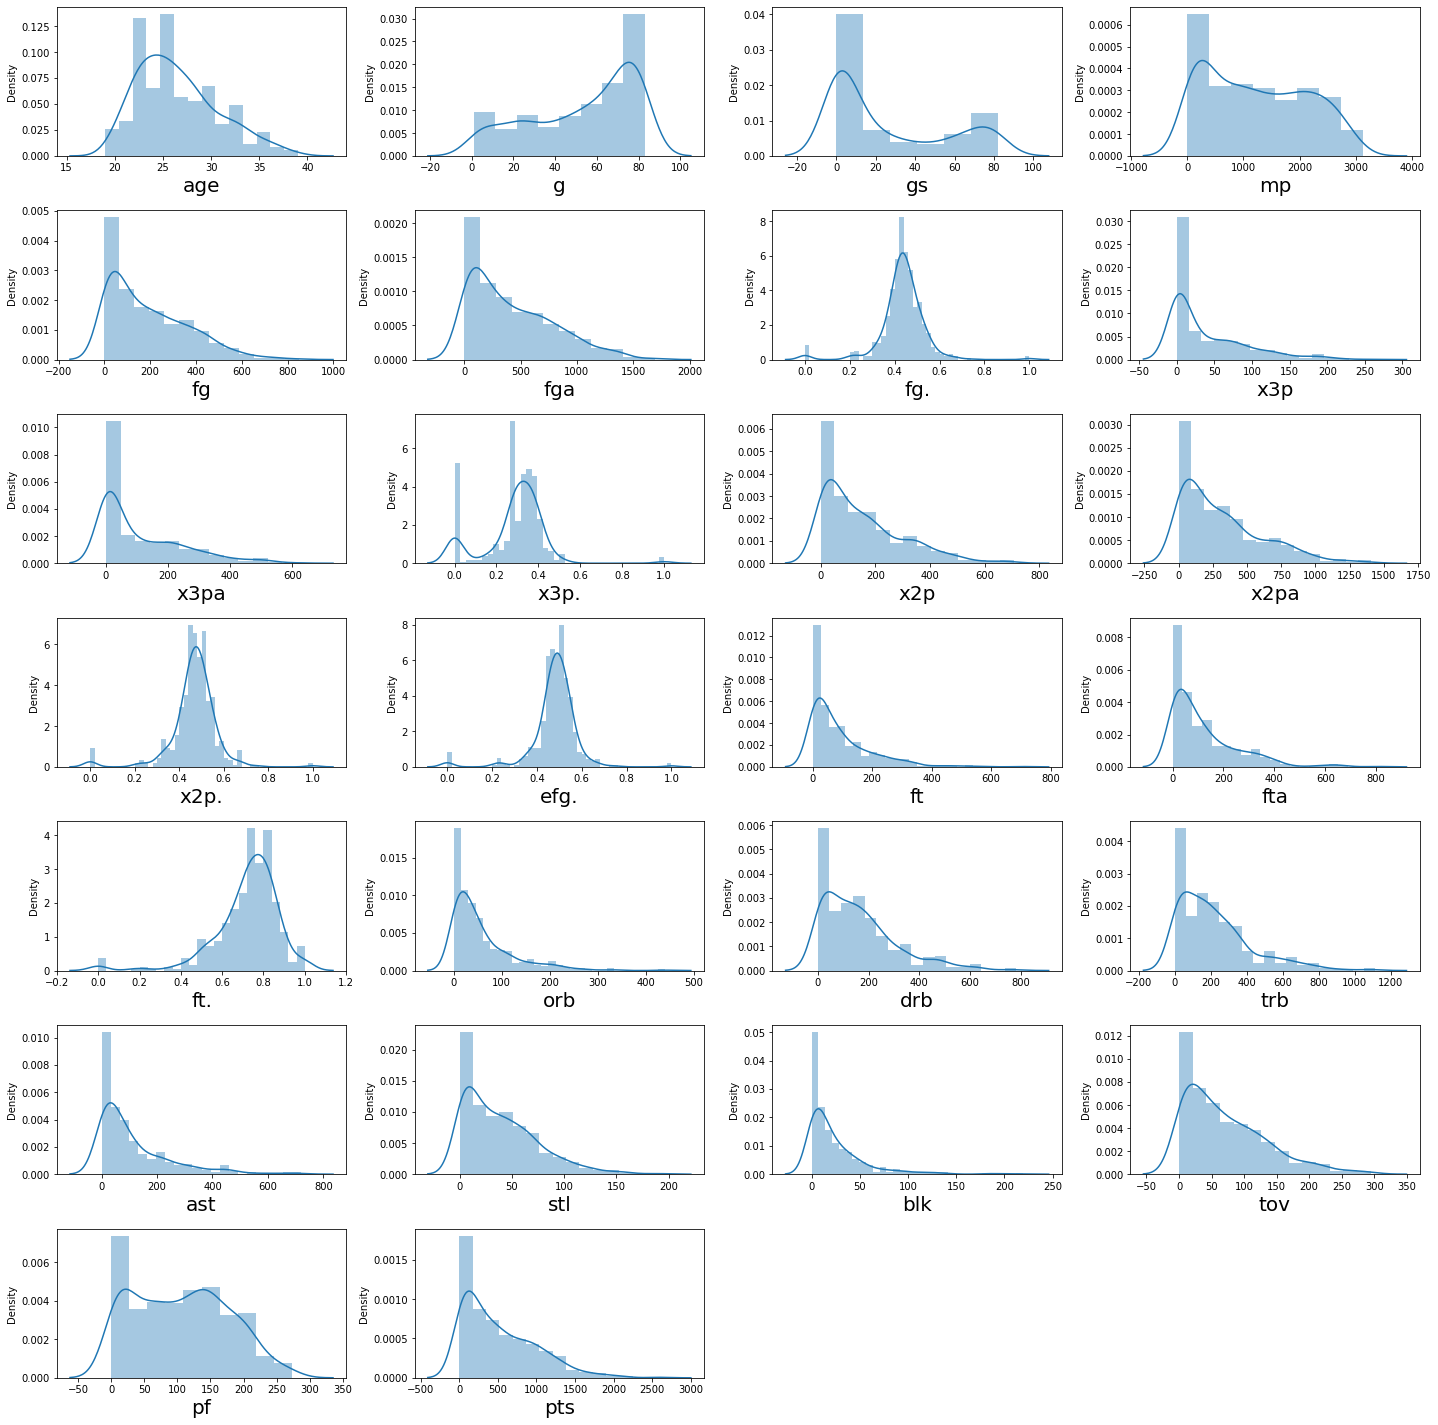

In [17]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in numerical_cols:
    if plotnumber<=36 :
        ax = plt.subplot(9,4,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

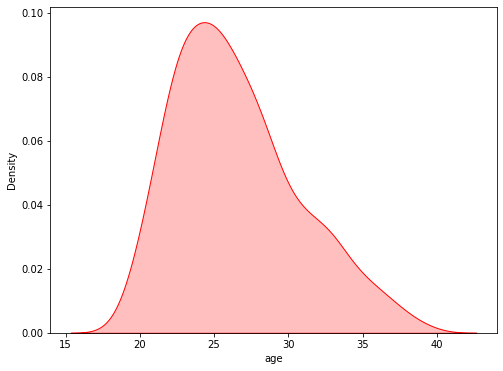

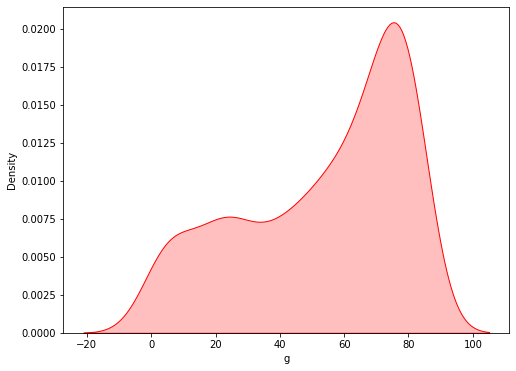

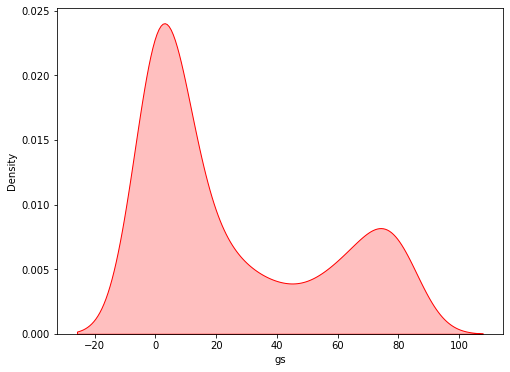

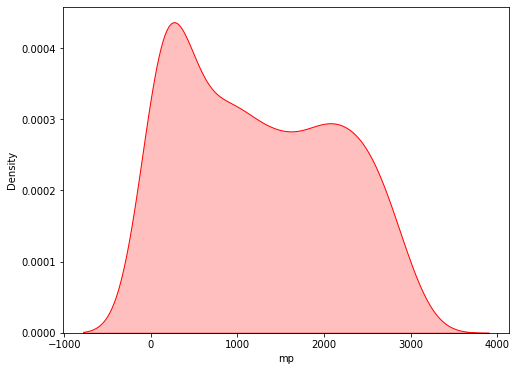

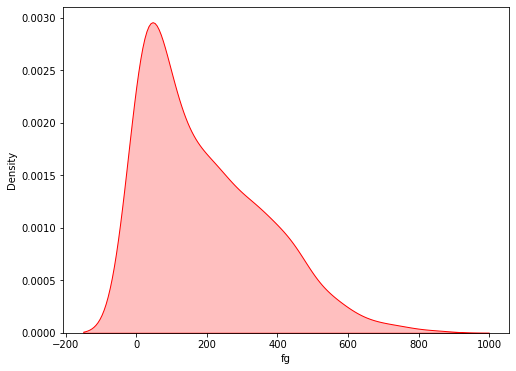

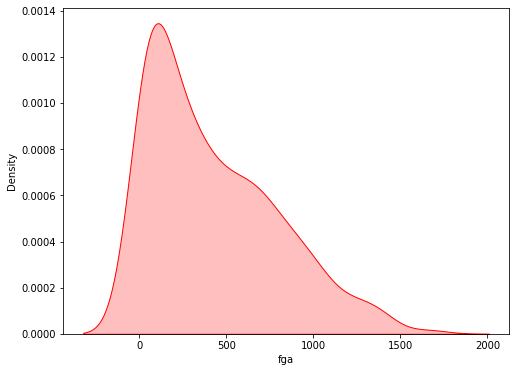

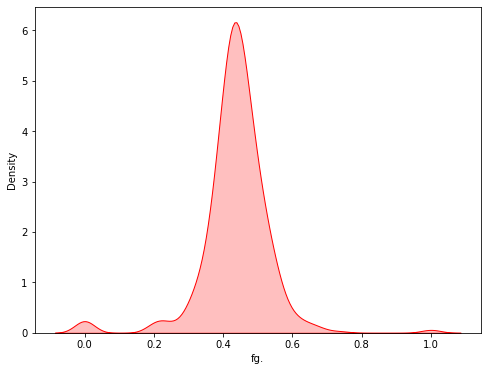

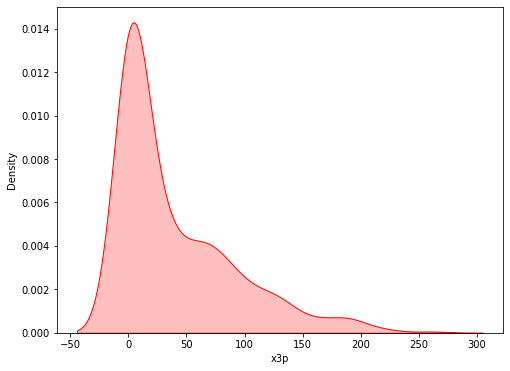

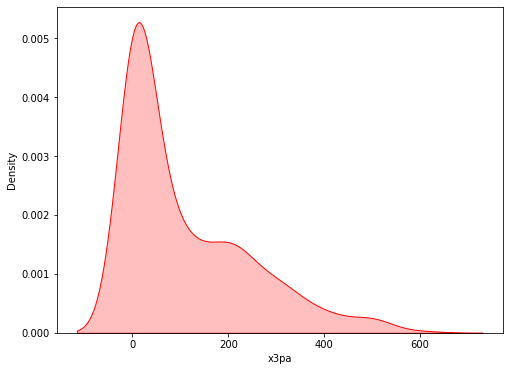

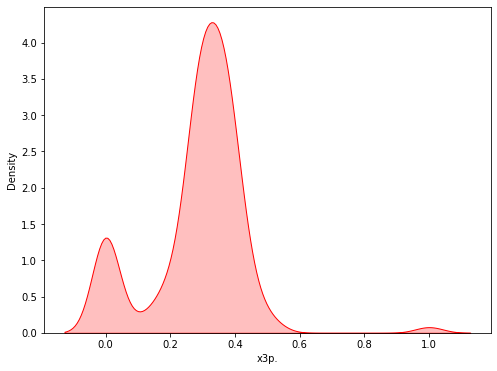

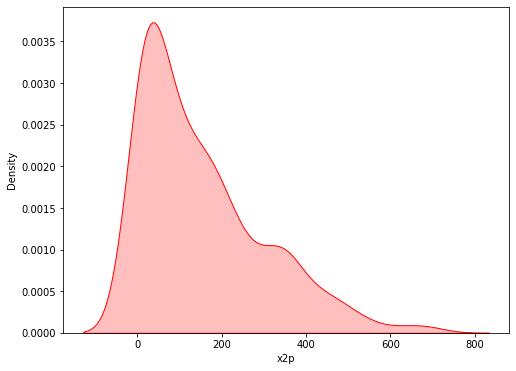

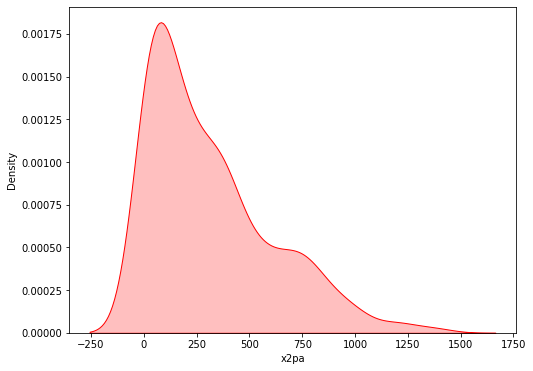

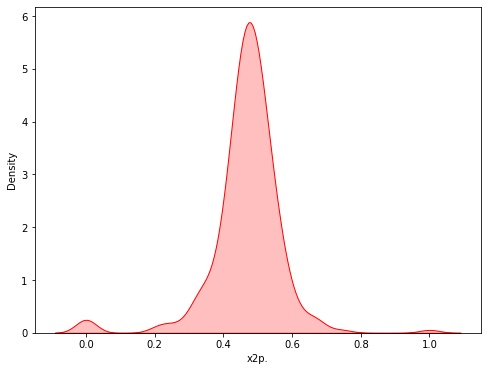

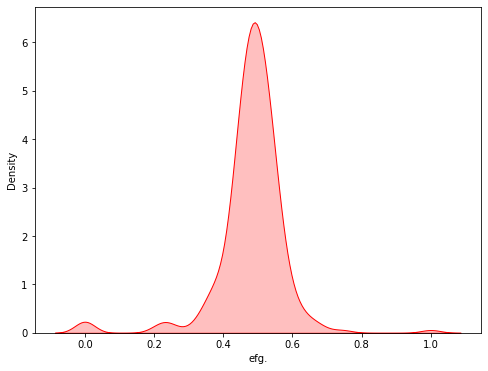

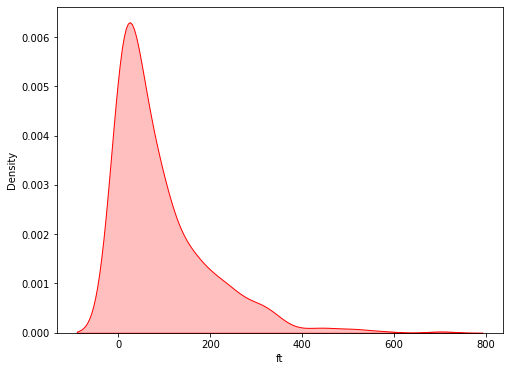

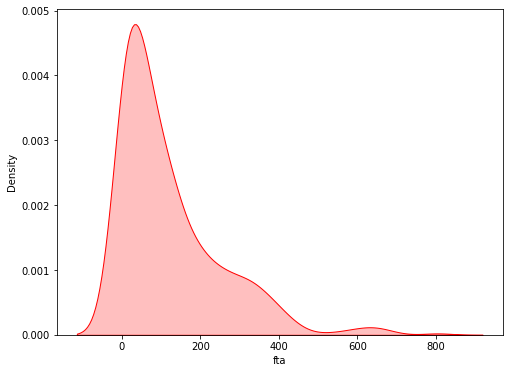

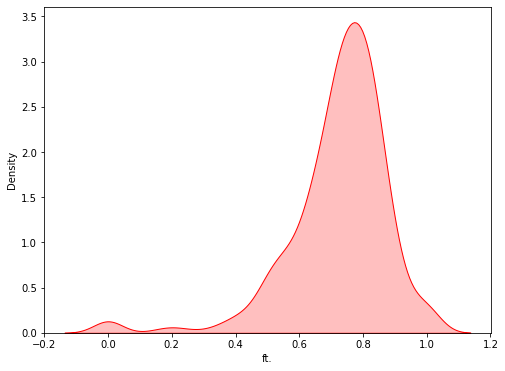

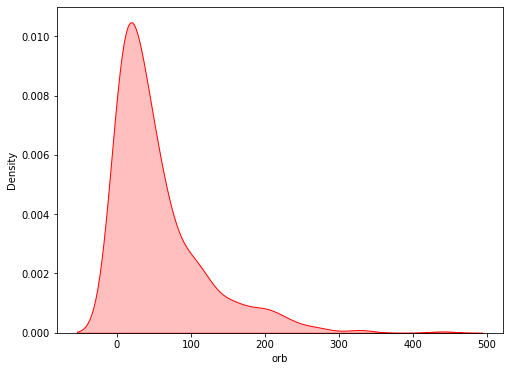

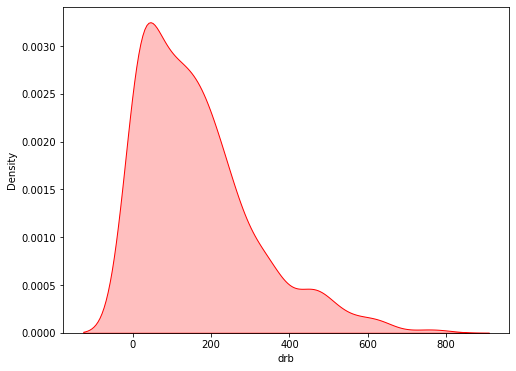

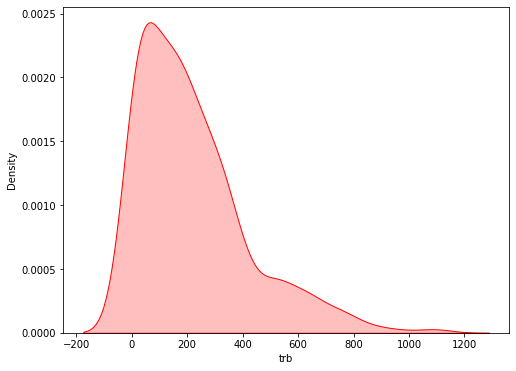

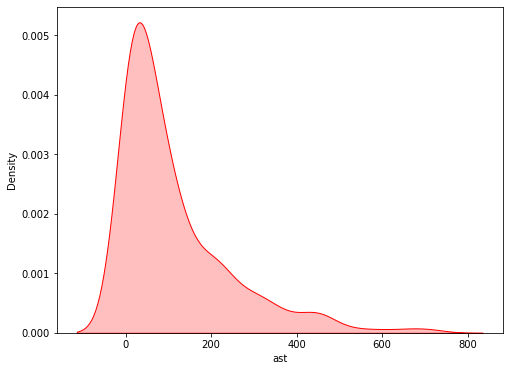

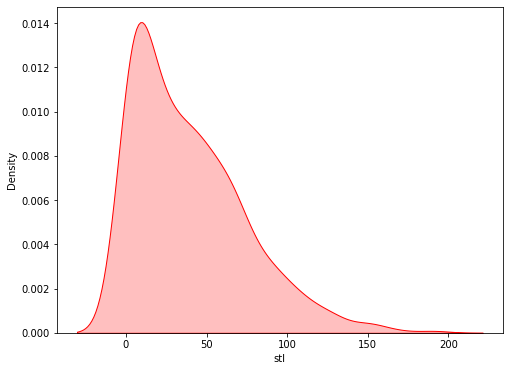

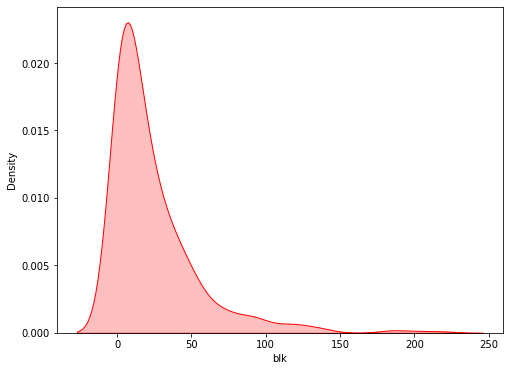

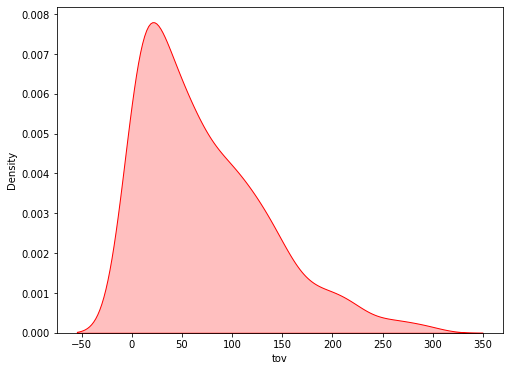

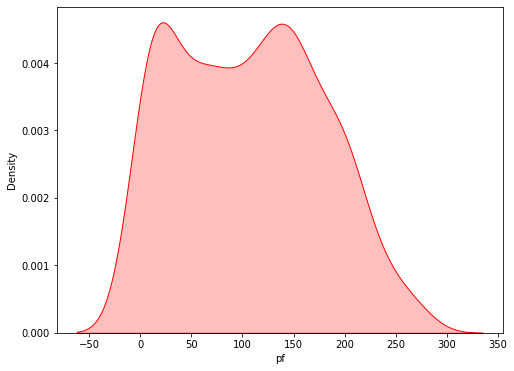

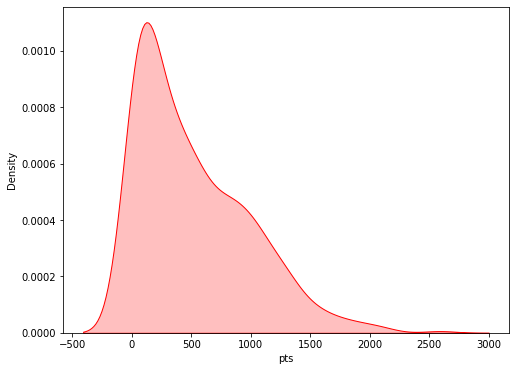

In [18]:
# KDE Plot
for col in numerical_cols:
    plt.figure(figsize= (8,6))
    ax = sns.kdeplot(data[col], shade=True, color="r")
    plt.show()

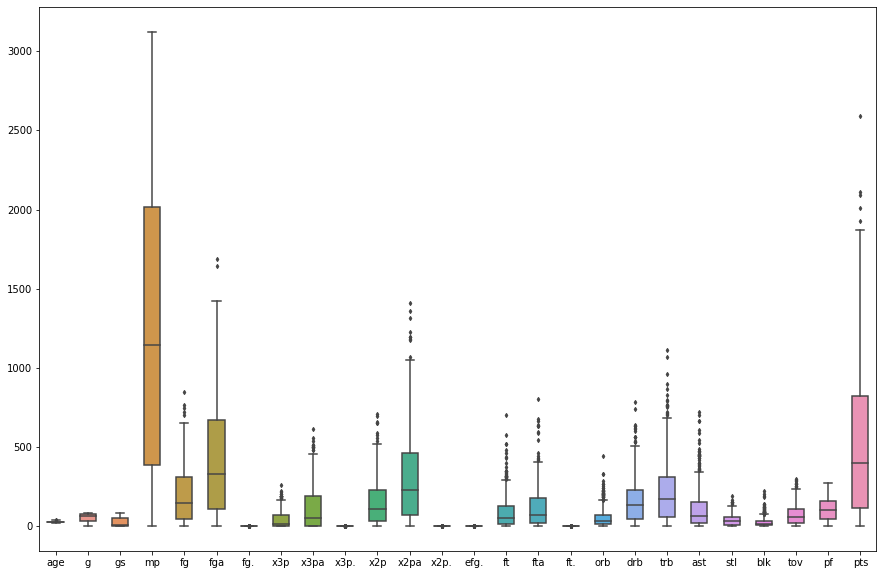

In [19]:
# Print boxplot to portray outliers
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data, width= 0.5,ax=ax,  fliersize=3)
plt.show()

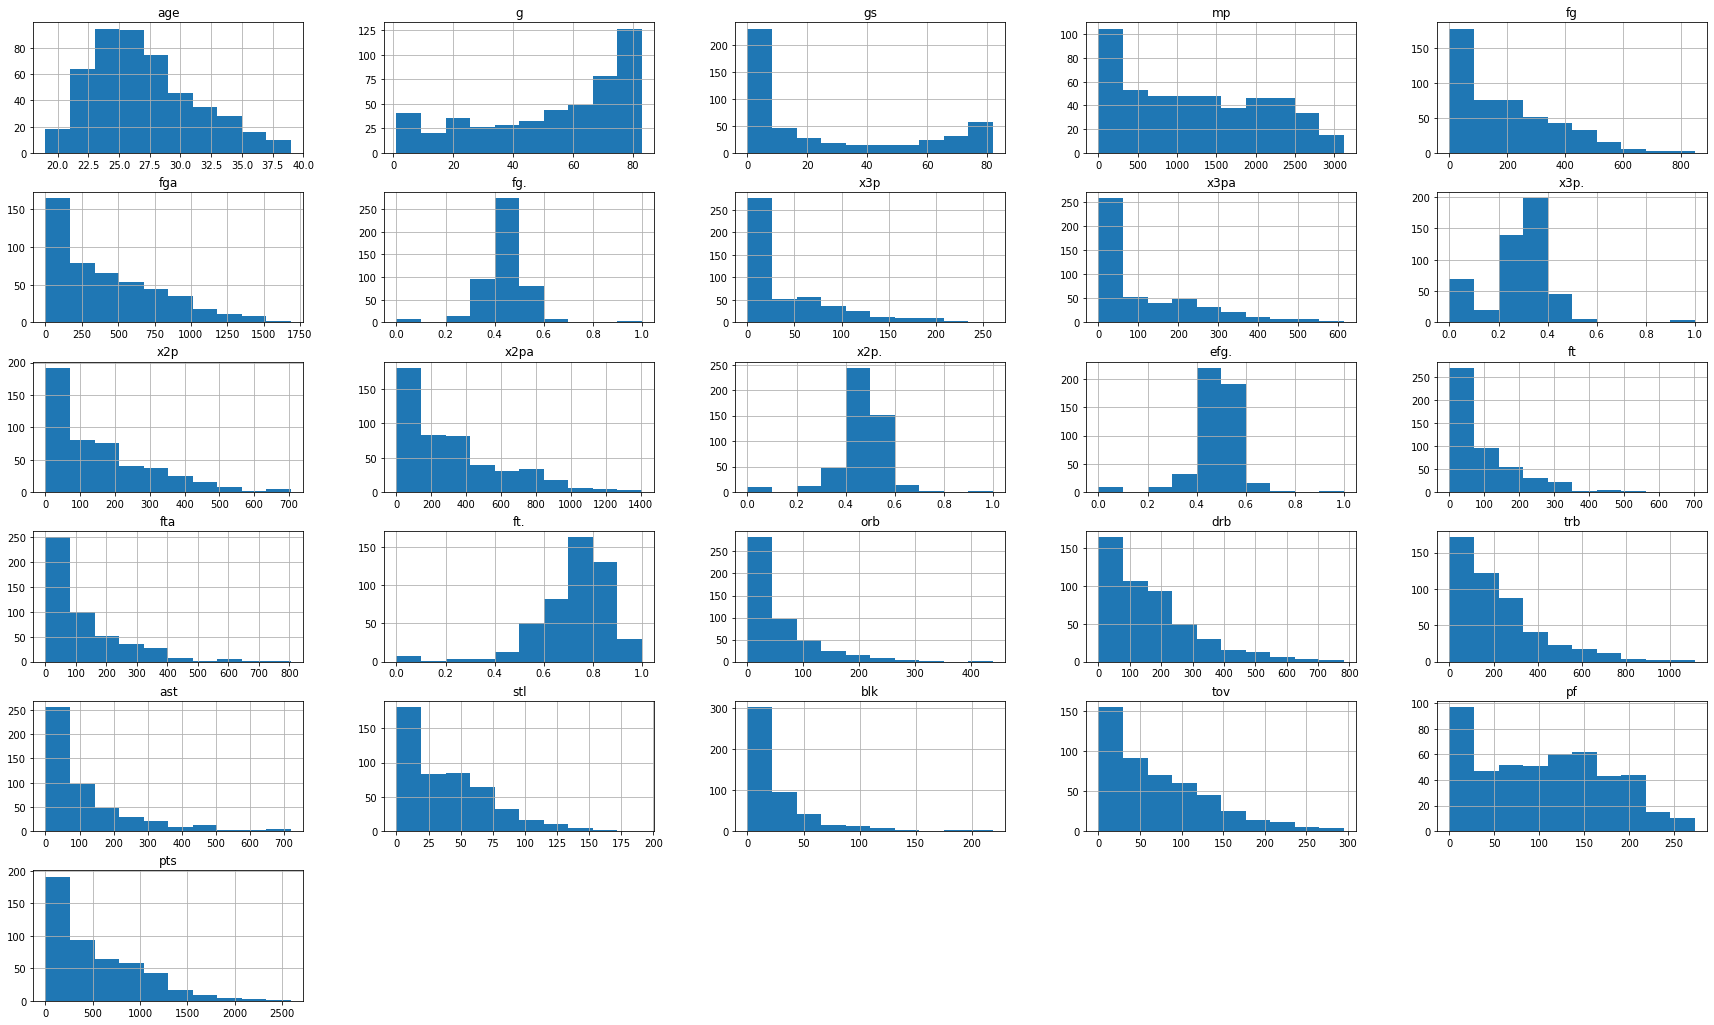

In [20]:
# Visualize histogram of dataset
data.hist(figsize= (30,18), bins= 10)
plt.show()

In [21]:
# Let us see the cardanilatity of each column for the categorical columns in train and test set
# Unique value sin each columns
for cols in categorical_features:
    print("Unique values in", cols,  "column in dataset:", data[cols].nunique())
    print("*"*80)

Unique values in pos column in dataset: 7
********************************************************************************
Unique values in bref_team_id column in dataset: 31
********************************************************************************


In [22]:
# Let's perform basic analysis of data
data_test = data[categorical_cols]

data_test.head()

,pos,bref_team_id,pts
0,SF,TOT,171
1,C,OKC,265
2,PF,TOT,362
3,SG,ORL,1330
4,C,NOP,328


In [23]:
#  Top points scored by position
data_test.groupby('pos', as_index=False,sort= True).sum().sort_values(by='pts', ascending=False, inplace=False).head(5)

,pos,pts
3,PF,54819
6,SG,54539
4,PG,51947
5,SF,48905
0,C,38256


In [24]:
#  Average points scored by position
data_test.groupby('pos', as_index=False,sort= True).mean().sort_values(by='pts', ascending=False, inplace=False).head(5)

,pos,pts
4,PG,611.141176
3,PF,571.031250
6,SG,500.357798
5,SF,493.989899
0,C,425.066667


In [25]:
# Top points scored by bref_team_id
data_test.groupby('bref_team_id', as_index=False).sum().sort_values(by='pts', ascending=False, inplace=False).head(5)

,bref_team_id,pts
28,TOT,21502
24,POR,8753
23,PHO,8629
6,DAL,8597
12,LAC,8582


In [26]:
# Average points scored by bref_team_id
data_test.groupby('bref_team_id', as_index=False).mean().sort_values(by='pts', ascending=False, inplace=False).head(5)

,bref_team_id,pts
9,GSW,655.833333
27,TOR,642.100000
7,DEN,639.833333
11,IND,612.083333
17,MIN,609.142857


In [27]:
# Points scored by bref_team_id and position
data_test.groupby(['pos','bref_team_id'], as_index=False).sum().sort_values(by='pts', ascending=False, inplace=False).head(5)

,pos,bref_team_id,pts
123,SF,TOT,6403
154,SG,TOT,5686
92,PG,TOT,4340
149,SG,PHO,3031
61,PF,TOT,2908


In [28]:
# replacing zero values with the mean of the column

for cols in numerical_features:
  data[cols] = data[cols].replace(0,data[cols].mean())

data.head()

,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,SF,23,TOT,63,25.571726,847,66.0,141.0,0.468,4.000000,15.000000,0.266667,62.0,126.0,0.492063,0.482,35.0,53.0,0.660,72.0,144.0,216.0,28.0,23.0,26.0,30.0,122.0,171
1,C,20,OKC,81,20.000000,1197,93.0,185.0,0.503,39.613306,110.130977,0.285111,93.0,185.0,0.502703,0.503,79.0,136.0,0.581,142.0,190.0,332.0,43.0,40.0,57.0,71.0,203.0,265
2,PF,27,TOT,53,12.000000,961,143.0,275.0,0.520,39.613306,110.130977,0.285111,143.0,275.0,0.520000,0.520,76.0,119.0,0.639,102.0,204.0,306.0,38.0,24.0,36.0,39.0,108.0,362
3,SG,28,ORL,73,73.000000,2552,464.0,1011.0,0.459,128.000000,300.000000,0.426667,336.0,711.0,0.472574,0.522,274.0,336.0,0.815,32.0,230.0,262.0,248.0,35.0,3.0,146.0,136.0,1330
4,C,25,NOP,56,30.000000,951,136.0,249.0,0.546,39.613306,1.000000,0.285111,136.0,248.0,0.548387,0.546,56.0,67.0,0.836,94.0,183.0,277.0,40.0,23.0,46.0,63.0,187.0,328


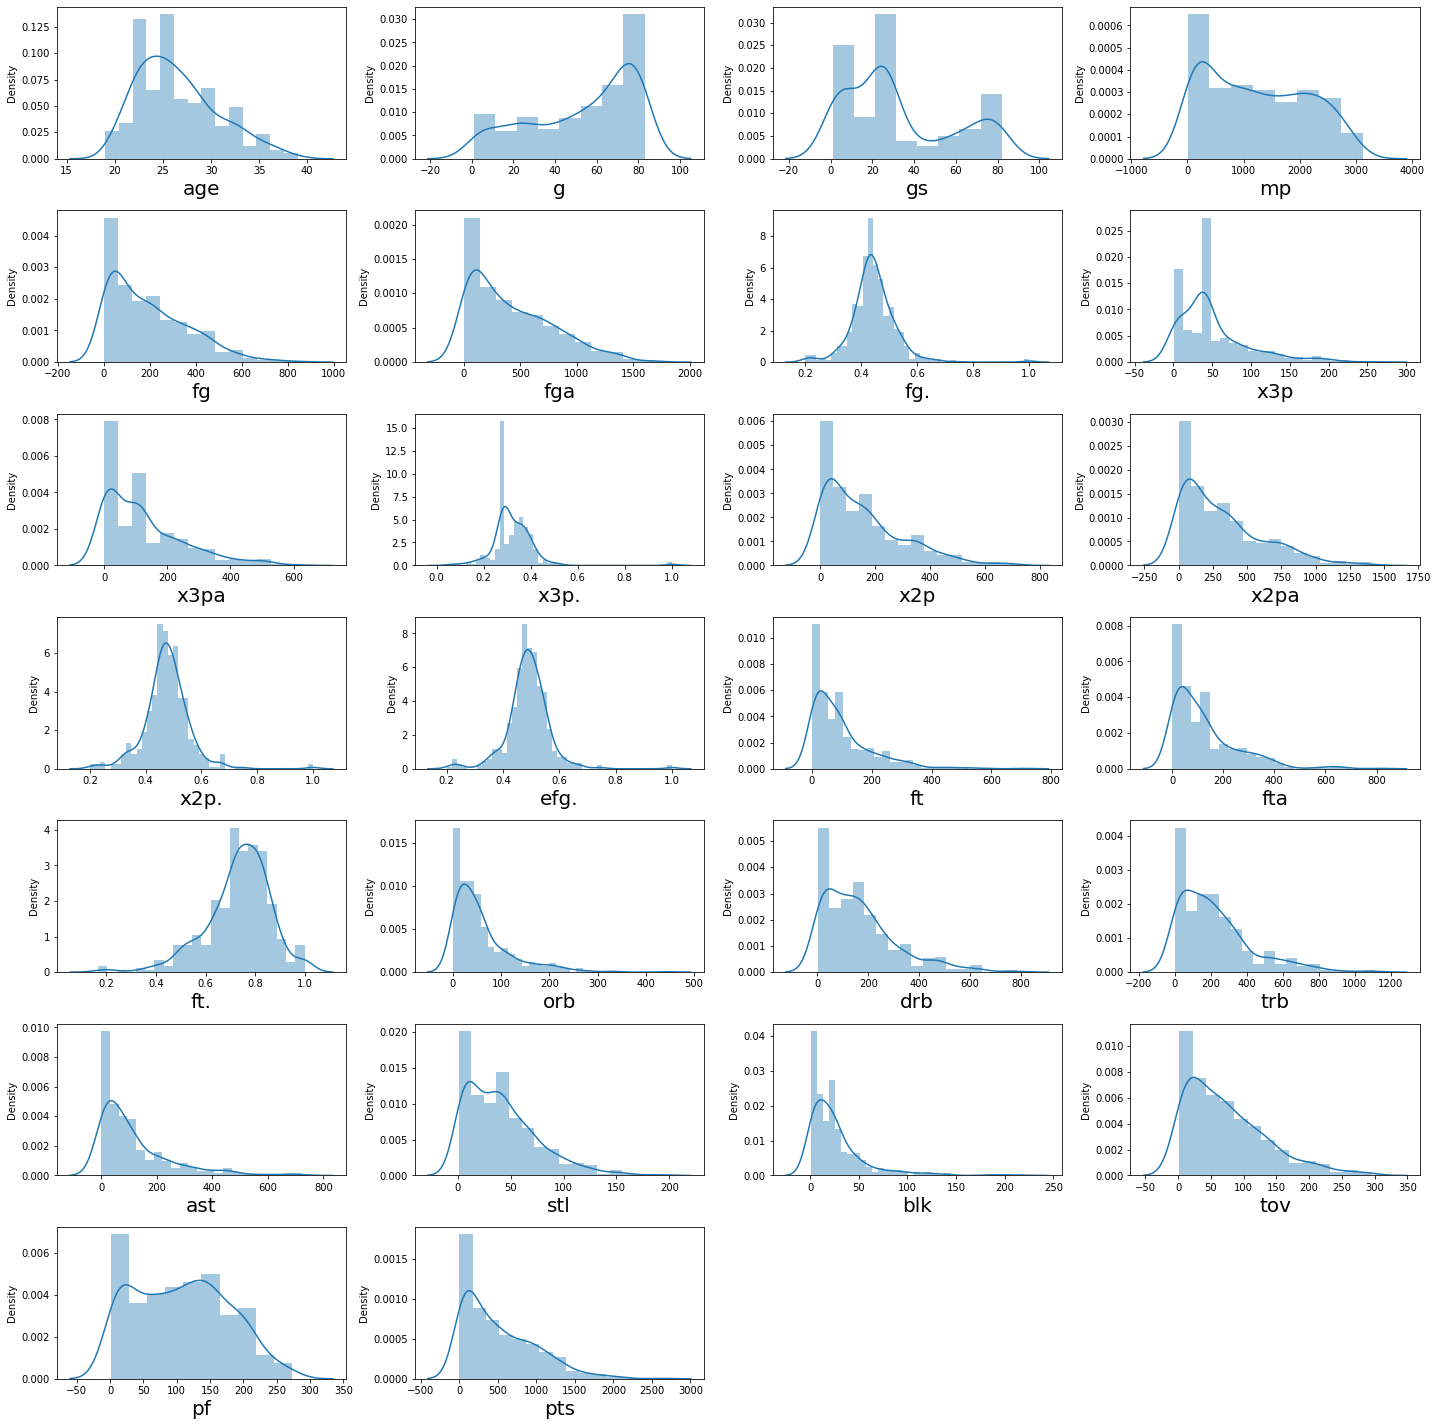

In [29]:
# let's see how data is distributed for every column after the above step
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in numerical_cols:
    if plotnumber<=36 :
        ax = plt.subplot(9,4,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [30]:
# Calculate the skewness and kurtosis values for numerical type columns
for col in numerical_cols:
    print(col)
    print("skewness:", data[col].skew())
    print("kurtosis:", data[col].kurtosis())
    print('-'*35)

age
skewness: 0.6654038420733254
kurtosis: -0.12945080094456252
-----------------------------------
g
skewness: -0.6253391673187659
kurtosis: -0.9311504338228573
-----------------------------------
gs
skewness: 0.6782764594981532
kurtosis: -0.8425426447133546
-----------------------------------
mp
skewness: 0.25039553810415427
kurtosis: -1.2222149947416392
-----------------------------------
fg
skewness: 0.9188942084512299
kurtosis: 0.33322752828989355
-----------------------------------
fga
skewness: 0.8532824777856636
kurtosis: 0.0006203187607138894
-----------------------------------
fg.
skewness: 1.2994204812683026
kurtosis: 9.858209178214537
-----------------------------------
x3p
skewness: 1.5559953137061866
kurtosis: 2.6263023853495318
-----------------------------------
x3pa
skewness: 1.2405855094764713
kurtosis: 1.1704987439331038
-----------------------------------
x3p.
skewness: 2.9658959651670314
kurtosis: 21.843367087604733
-----------------------------------
x2p
skewness:

In [31]:
# Check for outliers
from scipy import stats
zscore = np.abs(stats.zscore(data[numerical_cols]))
zscore

array([[0.83677633, 0.3852869 , 0.25795252, ..., 0.709002  , 0.20853131,
        0.73538599],
       [1.55210112, 1.09685132, 0.47422663, ..., 0.04312939, 1.36622365,
        0.53535746],
       [0.11699006, 0.01002666, 0.7847575 , ..., 0.56283484, 0.00843634,
        0.32894504],
       ...,
       [0.35989314, 1.01778861, 1.77712224, ..., 1.48350539, 1.50914863,
        1.91605599],
       [1.31365952, 1.13638268, 1.13410474, ..., 0.21672334, 0.89457122,
        0.05656577],
       [0.59833473, 0.6620064 , 0.90120658, ..., 0.22177814, 0.42291878,
        0.25021041]])

In [32]:
## For simplicity remove all data with outliers
data_clean = data.copy()
data_clean = data_clean[(zscore <3).all(axis = 1)]
print("The shape of the original dataframe is :", data.shape)
print("The shape of the clean dataframe is :", data_clean.shape)

deleted_entries = data.shape[0] - data_clean.shape[0]
print("Entries deleted in the dataframe are :",  deleted_entries)

The shape of the original dataframe is : (481, 28)
The shape of the clean dataframe is : (413, 28)
Entries deleted in the dataframe are : 68


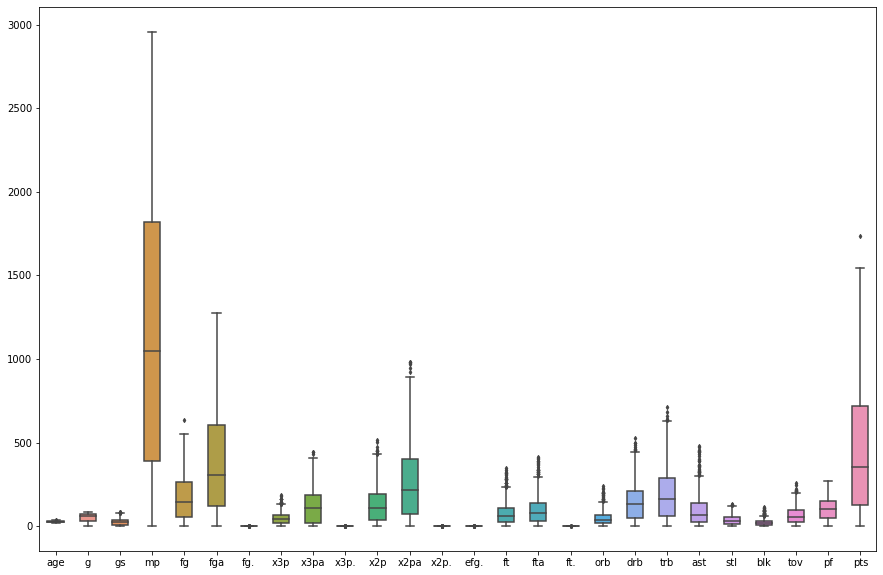

In [33]:
# Examine cleaned dataframe
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data_clean, width= 0.5,ax=ax,  fliersize=3)
plt.show()

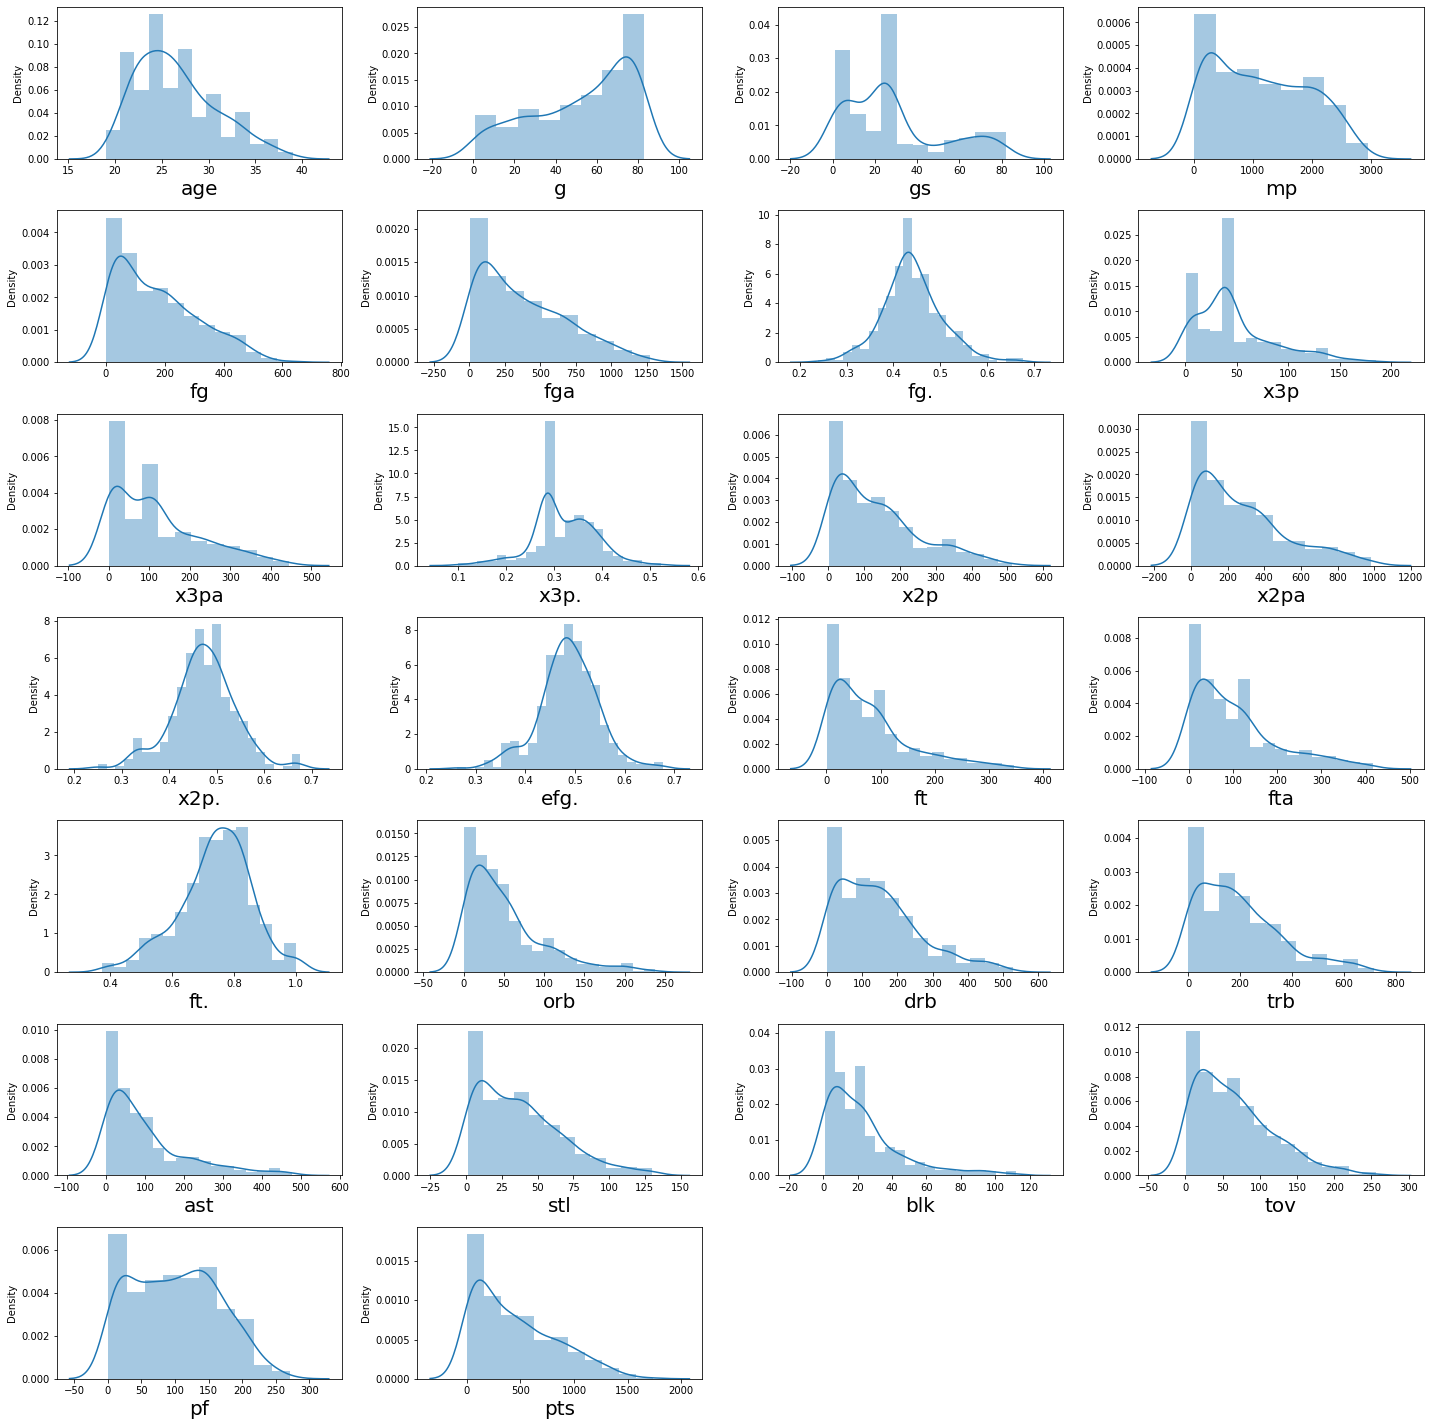

In [34]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in numerical_cols:
    if plotnumber<=36 :
        ax = plt.subplot(9,4,plotnumber)
        sns.distplot(data_clean[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [87]:
# Define continous and categorical features as one new dataframe
# Extract numerical columns from train dataframe
numerical_cols = [cname for cname in data_clean.columns if
                data_clean[cname].dtype in ['int64', 'float64']]


numerical_features = numerical_cols[:-1]


print(numerical_features)


['g', 'gs', 'mp', 'fg', 'fga', 'x3p', 'x3pa', 'x2p', 'x2pa', 'ft', 'fta', 'drb', 'trb', 'ast', 'stl', 'tov', 'pf']


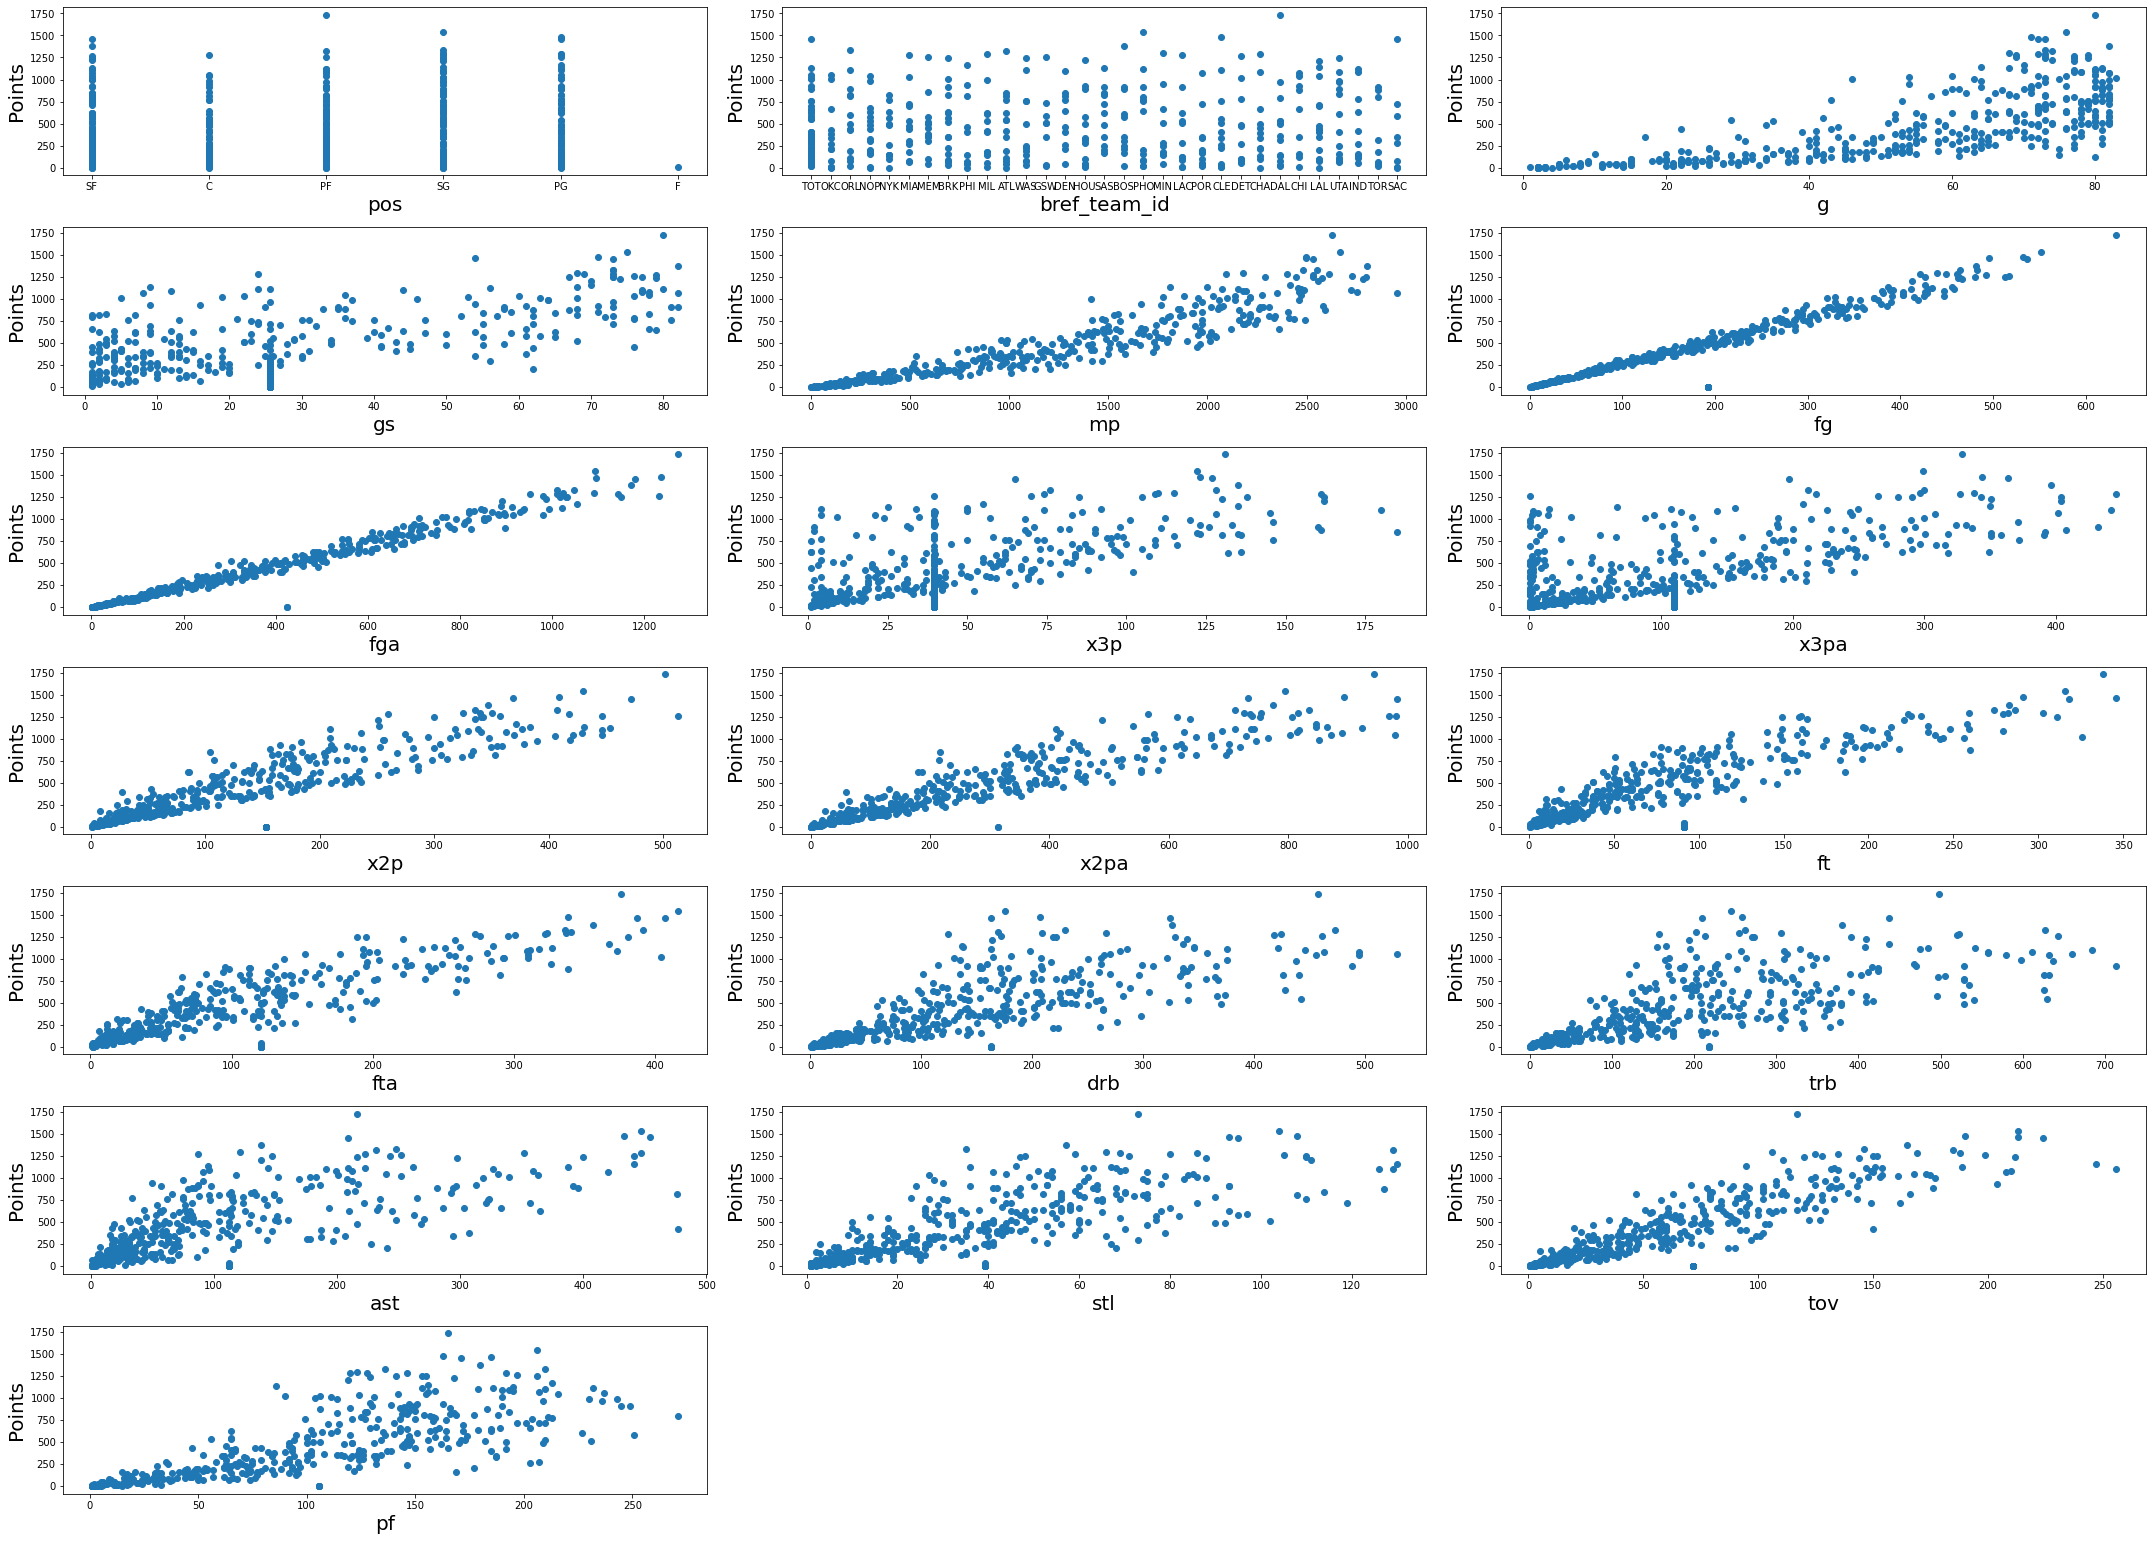

In [88]:
# create X and y

X = data_clean.drop(columns = ['pts'])
y = data_clean['pts']

plt.figure(figsize=(30,24), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=24 :
        ax = plt.subplot(8,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Points',fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [89]:
# Print X

X.head()

,pos,bref_team_id,g,gs,mp,fg,fga,x3p,x3pa,x2p,x2pa,ft,fta,drb,trb,ast,stl,tov,pf
0,SF,TOT,63,25.571726,847,66.0,141.0,4.000000,15.000000,62.0,126.0,35.0,53.0,144.0,216.0,28.0,23.0,30.0,122.0
1,C,OKC,81,20.000000,1197,93.0,185.0,39.613306,110.130977,93.0,185.0,79.0,136.0,190.0,332.0,43.0,40.0,71.0,203.0
2,PF,TOT,53,12.000000,961,143.0,275.0,39.613306,110.130977,143.0,275.0,76.0,119.0,204.0,306.0,38.0,24.0,39.0,108.0
3,SG,ORL,73,73.000000,2552,464.0,1011.0,128.000000,300.000000,336.0,711.0,274.0,336.0,230.0,262.0,248.0,35.0,146.0,136.0
4,C,NOP,56,30.000000,951,136.0,249.0,39.613306,1.000000,136.0,248.0,56.0,67.0,183.0,277.0,40.0,23.0,63.0,187.0


In [90]:
# pRINT y
y[0:5]

0     171
1     265
2     362
3    1330
4     328
Name: pts, dtype: int64

In [91]:
# All new categorical columns
object_cols = [col for col in X.columns if X[col].dtype == "object"]
object_cols

['pos', 'bref_team_id']

In [92]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['pos']

Categorical columns that will be dropped from the dataset: ['bref_team_id']


In [93]:
# Drop high cardinality columns
X.drop(high_cardinality_cols, axis = 1, inplace= True)

In [94]:
# Perform one hot encoding
X =  pd.get_dummies(X, prefix= low_cardinality_cols, columns= low_cardinality_cols, drop_first= True)

X.head()

,g,gs,mp,fg,fga,x3p,x3pa,x2p,x2pa,ft,fta,drb,trb,ast,stl,tov,pf,pos_F,pos_PF,pos_PG,pos_SF,pos_SG
0,63,25.571726,847,66.0,141.0,4.000000,15.000000,62.0,126.0,35.0,53.0,144.0,216.0,28.0,23.0,30.0,122.0,0,0,0,1,0
1,81,20.000000,1197,93.0,185.0,39.613306,110.130977,93.0,185.0,79.0,136.0,190.0,332.0,43.0,40.0,71.0,203.0,0,0,0,0,0
2,53,12.000000,961,143.0,275.0,39.613306,110.130977,143.0,275.0,76.0,119.0,204.0,306.0,38.0,24.0,39.0,108.0,0,1,0,0,0
3,73,73.000000,2552,464.0,1011.0,128.000000,300.000000,336.0,711.0,274.0,336.0,230.0,262.0,248.0,35.0,146.0,136.0,0,0,0,0,1
4,56,30.000000,951,136.0,249.0,39.613306,1.000000,136.0,248.0,56.0,67.0,183.0,277.0,40.0,23.0,63.0,187.0,0,0,0,0,0


In [114]:
# Let's scale our dataset
scalar = StandardScaler()

x_transform = scalar.fit_transform(X)

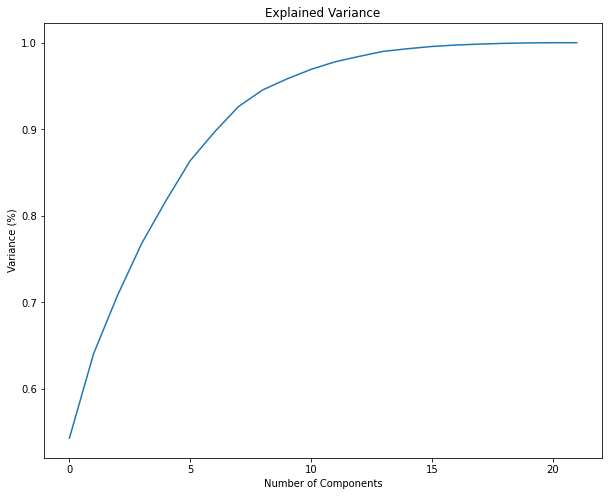

In [117]:
# Let us perform PCA for feature selection
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(x_transform)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [118]:
# We note that using 8 components above 90% of the varaition in data is captured
pca = PCA(n_components=8)
new_data = pca.fit_transform(x_transform)

principal_x = pd.DataFrame(new_data,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8'])

In [119]:
# Print the new dataframe based on 8 principal components
principal_x

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
0,-1.799390,1.160655,-1.332506,-1.314774,0.759854,-0.774593,0.904445,0.074511
1,0.288223,0.992917,-0.553558,-0.125269,-0.623196,0.030922,1.578131,0.296080
2,-0.428177,2.020114,0.174309,0.275490,-1.059838,0.881364,-0.641000,0.567055
3,6.119863,-1.631885,0.040045,2.349033,0.896384,-0.117703,-1.472617,-0.046549
4,-0.409567,1.302939,-0.050111,-0.092174,-0.158425,-0.213657,1.187944,-0.411524
...,...,...,...,...,...,...,...,...
408,-1.053768,-0.377428,-2.200527,-1.180995,-0.001827,-0.022204,-0.094813,0.656284
409,4.359460,-0.903478,1.036143,2.019592,1.176325,-0.894423,0.173570,1.800050
410,3.698589,-1.947902,-0.748850,2.440034,0.017940,0.230686,-1.081843,1.957664
411,1.403480,1.431973,0.357277,0.066082,0.159444,-0.468626,1.360871,1.348479


In [128]:
# let's see how well our model perform on this new data
x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size = 0.30, random_state = 10)

In [129]:
# let's fit the data into kNN model and see how well it performs:
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)

# Let's examine performance of model
knn.score(x_train,y_train)

0.9668582086624213

In [130]:
# Let's examine performance of model
y_pred = knn.predict(x_test)

knn.score(x_test,y_test)

0.9539112217850689

In [131]:
# Print other metrics
print("The mean absolute error is :", mean_absolute_error(y_test, y_pred))

print("The mean absolute squared error is :", mean_squared_error(y_test, y_pred))

print("The root mean absolute squared error is :", np.sqrt(mean_squared_error(y_test, y_pred)))

The mean absolute error is : 58.80806451612904
The mean absolute squared error is : 7064.091290322581
The root mean absolute squared error is : 84.04814864304021


Let's try to increase the accuracy by using hyperparameter tuning.

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = { 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
               'leaf_size' : [5, 10, 15],
              'weights': ['uniform','distance'],
               'n_neighbors' : [3,5,7,9,10]
              }

In [135]:
# Start hyper-parameter tuning
gridsearch = GridSearchCV(knn, param_grid,verbose=3,cv= 5)
gridsearch.fit(x_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform, score=0.964, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform, score=0.940, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform, score=0.924, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform, score=0.953, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=uniform, score=0.911, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=3, weights=distance 
[CV]  algorithm=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance, score=0.956, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance, score=0.931, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance, score=0.951, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=9, weights=distance, score=0.930, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=10, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=10, weights=uniform, score=0.960, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n_neighbors=10, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=5, n_neighbors=10, weights=uniform, score=0.952, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=5, n

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 10, 15],
                         'n_neighbors': [3, 5, 7, 9, 10],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [136]:
# let's see the  best parameters according to gridsearch
gridsearch.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 5,
 'n_neighbors': 7,
 'weights': 'distance'}

In [137]:
# we will use the best parameters in our k-NN algorithm and check if accuracy is increasing.
knn = KNeighborsRegressor(algorithm = 'ball_tree', leaf_size =5, n_neighbors =7, weights='distance')
knn.fit(x_train,y_train)

knn.score(x_train,y_train)

1.0

In [138]:
# Let's see how it perfroms on the test data.
knn.score(x_test,y_test)

0.9558290710176253

In [139]:
#k-fold cross validation 
kfold = KFold(n_splits=12,random_state= 42)
kfold.get_n_splits(x_transform)

12

In [140]:
from statistics import mean
knn = KNeighborsRegressor(algorithm = 'ball_tree', leaf_size =5, n_neighbors =9, weights='distance')
cnt =0
count=[]
train_score =[]
test_score = []

for train_index,test_index in kfold.split(x_transform):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index] # our scaled data is an array so it can work on x[value]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
    knn.fit(X_train,y_train)
    train_score_ = knn.score(X_train,y_train)
    test_score_ =  knn.score(X_test,y_test)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    test_score.append(test_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and test score is :  ", test_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average test score is :  ", mean(test_score))

for k =  1
train_score is :   1.0 and test score is :   0.9646465322197538
for k =  2
train_score is :   1.0 and test score is :   0.9703183224168805
for k =  3
train_score is :   1.0 and test score is :   0.9793284153713732
for k =  4
train_score is :   1.0 and test score is :   0.9748994907041066
for k =  5
train_score is :   1.0 and test score is :   0.9819049178485091
for k =  6
train_score is :   1.0 and test score is :   0.9667506889331605
for k =  7
train_score is :   1.0 and test score is :   0.9663185795826602
for k =  8
train_score is :   1.0 and test score is :   0.9777519320037085
for k =  9
train_score is :   1.0 and test score is :   0.9512046508880462
for k =  10
train_score is :   1.0 and test score is :   0.9166107957087611
for k =  11
train_score is :   1.0 and test score is :   0.9847605283507879
for k =  12
train_score is :   1.0 and test score is :   0.9735641473328113
************************************************
************************************************

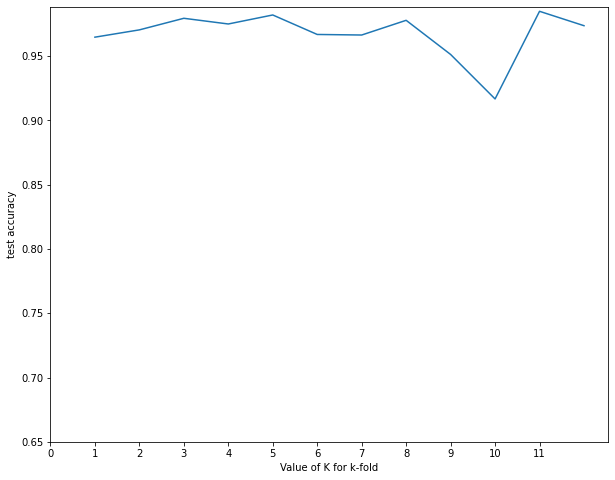

In [112]:
# let's plot the test_accuracy with the value of k in k-fold

plt.plot(count,test_score)
plt.xlabel('Value of K for k-fold')
plt.ylabel('test accuracy')
plt.xticks(np.arange(0, 12, 1)) 
plt.yticks(np.arange(0.65, 1, 0.05)) 
plt.show()

In [141]:
# let's save the model
import pickle

with open('KNN.sav', 'wb') as f:
    pickle.dump(knn,f)
    
with open('standardScalar.sav', 'wb') as f:
    pickle.dump(scalar,f)